In [1]:
import os
def get_list_of_files(data_path: str=r'./splits') -> list[tuple[str, str]]:
    '''Returns a list of tuples of the form (path_to_input_sample, path_to_label)
    
    Parameters:
    data_path (str): path to the root of the data directory
    
    Returns:
    list[tuple[str, str]]: List of file paths with corresponding ground truth labels
    '''
    
    # get list of patch ids. list comprehension pretty much says "look at the 
    # items in the data_path directory and if they are directories, add them to 
    # the list"
    file_paths = []
    data_folders = ["test", "train", "val"]
    # patch_ids = [sub_dir for sub_dir in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, sub_dir))]
    
    for each in data_folders:
        # ../splits/[test/train/val]/input
        input_folder = os.path.join(data_path, each, 'input')
        # ../splits/[test/train/val]/target 
        target_folder = os.path.join(data_path, each, 'target')
    
        # check to make sure folders exist
        if not os.path.isdir(input_folder): raise FileNotFoundError(f'Input folder {input_folder} not found')
        if not os.path.isdir(target_folder): raise FileNotFoundError(f'Target folder {target_folder} not found')
        
        # grab tifs
        input_tifs = [f for f in os.listdir(input_folder) if f.endswith('.tif')]
        
        for input_tif in input_tifs:
            # try to look for corresponding tifs in target dir
            target_tif = os.path.join(target_folder, input_tif)
            if os.path.isfile(target_tif):
                file_paths.append((os.path.join(input_folder, input_tif), target_tif)) # add input_tif's and matching target tif's loc
            
    return file_paths
    
    
file_paths = get_list_of_files(r'/home/aayamlord/GitHub/MSU_GCER/splits')
print(f'Found {len(file_paths)} files') # always a good idea to print out the number of files found
print(file_paths[240]) # take a look at the first file path input/target 2-tupledataset/raster/unet_data

Found 250 files
('/home/aayamlord/GitHub/MSU_GCER/splits/val/input/2346787.tif', '/home/aayamlord/GitHub/MSU_GCER/splits/val/target/2346787.tif')


raster metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 256, 'height': 256, 'count': 3, 'crs': CRS.from_wkt('PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",32.5],PARAMETER["central_meridian",-89.75],PARAMETER["scale_factor",0.9998335],PARAMETER["false_easting",500000],PARAMETER["false_northing",1300000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(1.0, 0.0, 354141.4772286933,
       0.0, -1.0, 1186718.4901301984)}
raster shape: (3, 256, 256)
red band raster shape: (256, 256)


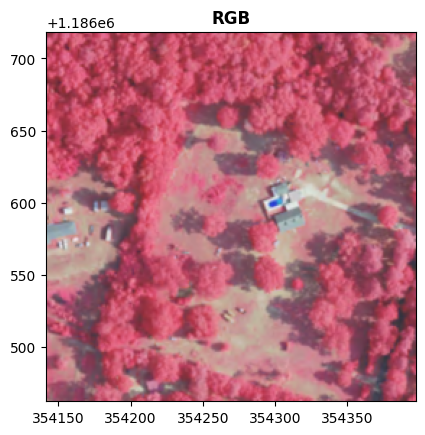

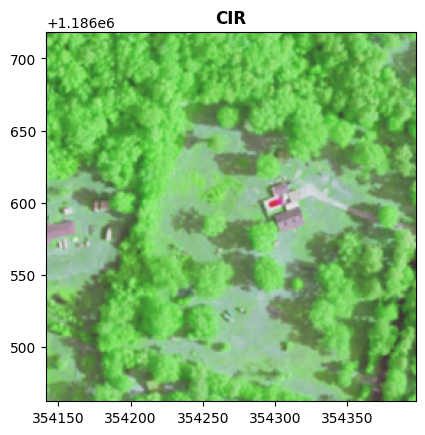

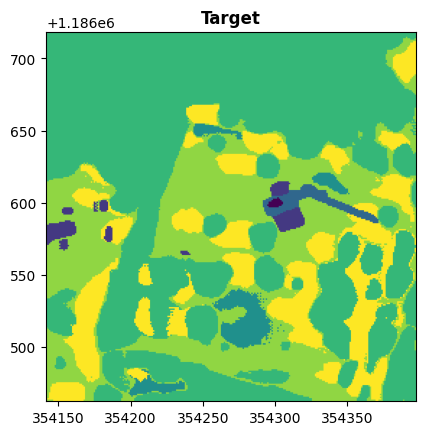

<Axes: title={'center': 'Target'}>

In [2]:
import rasterio
import numpy as np
from rasterio.plot import show

src_file = file_paths[0][0] # first sample, only the input data
with rasterio.open(src_file) as src:
    meta = src.meta # grab geo metadata
    data = src.read() # grab raster data (as numpy array)
    red_band = src.read(1) # only grab red band (as numpy array)
    
print('raster metadata:', meta)
print('raster shape:', data.shape)
print('red band raster shape:', red_band.shape)

data_rgb = data[:3] # create RGB image
show(data_rgb, transform=meta['transform'], vmin=0, vmax=255, title='RGB')
data_cir = data[[2, 0, 1], :, :] # grab only the G R NIR bands
show(data_cir, transform=meta['transform'], vmin=0, vmax=255, title='CIR')

target_file = file_paths[0][1] # first sample, only the target data
with rasterio.open(target_file) as src:
    target_meta = src.meta # grab geo metadata
    target = src.read() # grab raster data (as numpy array)
    
show(target, transform=target_meta['transform'], vmin=1, vmax=7, title='Target')

In [3]:
def print_array_info(array):
    print('array shape:', array.shape)
    print('array dtype:', array.dtype)
    print('array range:', array.min(), array.max())
    
print_array_info(data)
print_array_info(target)

array shape: (3, 256, 256)
array dtype: uint8
array range: 37 246
array shape: (1, 256, 256)
array dtype: uint8
array range: 1 8


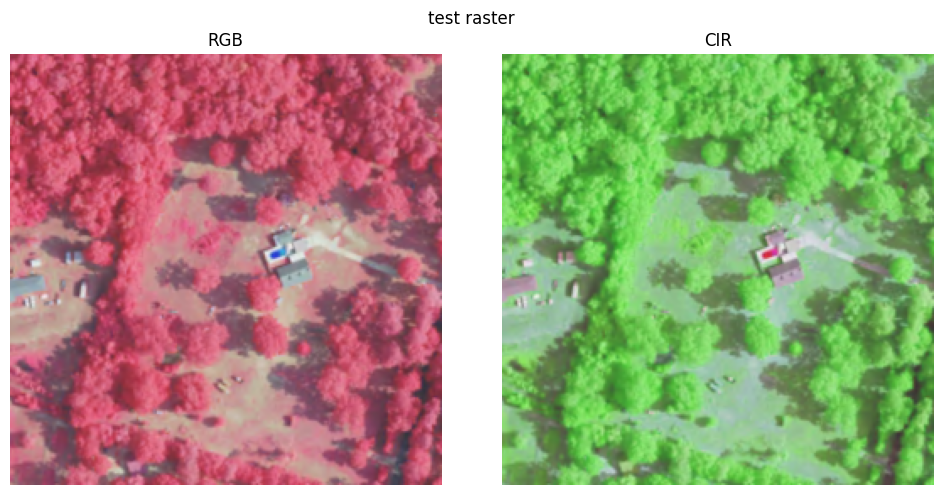

In [4]:
import matplotlib.pyplot as plt

def visualize_raster(raster, title=None):
    
    rgb = raster[:3] # create RGB image
    cir = raster[[2, 0, 1], :, :] # grab only the G R NIR bands
    
    rgb = rgb.transpose(1, 2, 0) # convert from (bands, rows, cols) to (rows, cols, bands)
    cir = cir.transpose(1, 2, 0)
    
    # create plt figure
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # plot RGB image
    ax[0].imshow(rgb, vmin=0, vmax=255)
    ax[0].set_title('RGB')
    ax[0].axis('off')
    
    # plot CIR image
    ax[1].imshow(cir, vmin=0, vmax=255)
    ax[1].set_title('CIR')
    ax[1].axis('off')
    
    if title is not None:
        fig.suptitle(title)
    
    fig.tight_layout() # formatting
    plt.show()
    
visualize_raster(data, 'test raster')

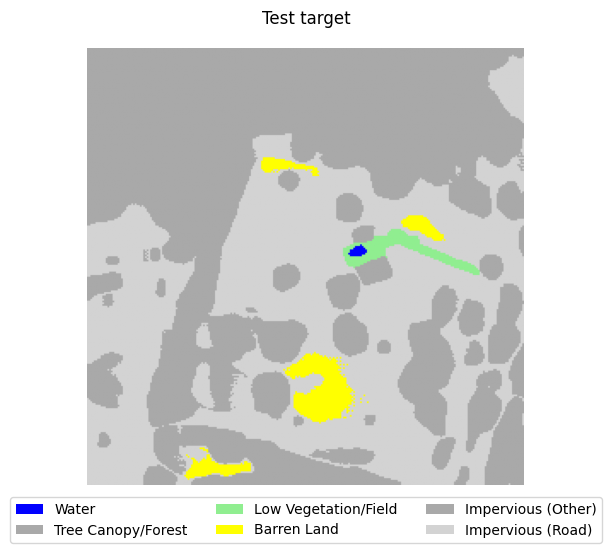

In [5]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

land_cover_colors = [
    'blue', # 1 - water
    'darkgray', # 2 - buildings and stuffs
    'lightgreen', # 3 - low vegetation/field
    'yellow', # 4 - barren land
    'darkgray', # 5 - impervious (other)
    'lightgray', # 6 - impervious (road)
] # no nodata samples in our dataset, so no need to add a nodata color

land_cover_labels = [
    'Water',
    'Tree Canopy/Forest',
    'Low Vegetation/Field',
    'Barren Land',
    'Impervious (Other)',
    'Impervious (Road)',
]

land_cover_cmap = ListedColormap(land_cover_colors, name='land-cover') # create color map object
land_cover_legend = [
    Patch(facecolor=land_cover_colors[0], label=land_cover_labels[0]),
    Patch(facecolor=land_cover_colors[1], label=land_cover_labels[1]),
    Patch(facecolor=land_cover_colors[2], label=land_cover_labels[2]),
    Patch(facecolor=land_cover_colors[3], label=land_cover_labels[3]),
    Patch(facecolor=land_cover_colors[4], label=land_cover_labels[4]),
    Patch(facecolor=land_cover_colors[5], label=land_cover_labels[5]),
]

def visualize_target(target, title=None):
    
    if target.ndim == 3: target = target.squeeze(0) # remove extra dimension if necessary
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    ax.imshow(target, cmap=land_cover_cmap, vmin=0, vmax=6) # plot target image
    ax.axis('off')
    
    fig.legend(handles=land_cover_legend, loc='lower center', bbox_to_anchor=(0.5, -.1), ncol=3) # add legend
    
    if title is not None:
        fig.suptitle(title)
        
    fig.tight_layout()
    plt.show()

target = target - 1# subtract 1 from all values to make the range 0-6 instead of 1-7
visualize_target(target, 'Test target')

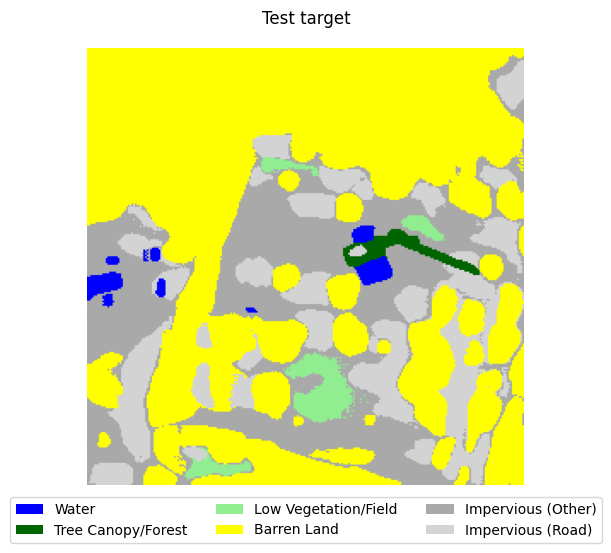

In [6]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

land_cover_colors = [
    'blue', # 1 - water
    'darkgreen', # 2 - tree canopy/forest
    'lightgreen', # 3 - low vegetation/field
    'yellow', # 4 - barren land
    'darkgray', # 5 - impervious (other)
    'lightgray', # 6 - impervious (road)
] # no nodata samples in our dataset, so no need to add a nodata color

land_cover_labels = [
    'Water',
    'Tree Canopy/Forest',
    'Low Vegetation/Field',
    'Barren Land',
    'Impervious (Other)',
    'Impervious (Road)',
]

land_cover_cmap = ListedColormap(land_cover_colors, name='land-cover') # create color map object
land_cover_legend = [
    Patch(facecolor=land_cover_colors[0], label=land_cover_labels[0]),
    Patch(facecolor=land_cover_colors[1], label=land_cover_labels[1]),
    Patch(facecolor=land_cover_colors[2], label=land_cover_labels[2]),
    Patch(facecolor=land_cover_colors[3], label=land_cover_labels[3]),
    Patch(facecolor=land_cover_colors[4], label=land_cover_labels[4]),
    Patch(facecolor=land_cover_colors[5], label=land_cover_labels[5]),
]

def visualize_target(target, title=None):
    
    if target.ndim == 3: target = target.squeeze(0) # remove extra dimension if necessary
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    ax.imshow(target, cmap=land_cover_cmap, vmin=0, vmax=6) # plot target image
    ax.axis('off')
    
    fig.legend(handles=land_cover_legend, loc='lower center', bbox_to_anchor=(0.5, -.1), ncol=3) # add legend
    
    if title is not None:
        fig.suptitle(title)
        
    fig.tight_layout()
    plt.show()

target = target - 1# subtract 1 from all values to make the range 0-6 instead of 1-7
visualize_target(target, 'Test target')

In [ ]:
# code is modified from https://github.com/milesial/Pytorch-UNet
# in order to comply with GPLv3, link to original code is provided above and 
# GPL v3 license is included in the repository

""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels): # remove bilinear option
        super(Up, self).__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2], mode='reflect')
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding_mode='reflect')

    def forward(self, x):
        return self.conv(x)

""" Full assembly of the parts to form the complete network """
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, channels=[16, 32, 64, 128, 256]):
        super(UNet, self).__init__()
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.channels = channels
        
        # need to use nn.ModuleList since encoder and decoder are lists of nn.Modules
        self.encoder = nn.ModuleList([(DoubleConv(n_channels, channels[0]))])
        for i in range(len(channels) - 1): 
            self.encoder.append(Down(channels[i], channels[i+1]))
            
        self.decoder = nn.ModuleList([])
        for i in range(len(channels) - 1, 0, -1):
            self.decoder.append(Up(channels[i], channels[i-1]))
        
        self.outc = (OutConv(channels[0], n_classes))

    def forward(self, x):
        
        encoder_layer_outputs = [] # need to store outputs from each layer in the encoder
        for layer in self.encoder:
            x = layer(x)
            if len(encoder_layer_outputs) < len(self.encoder) - 1: # don't save output from last encoder layer
                encoder_layer_outputs.append(x)
        
        # pass output from each encoder layer to corresponding decoder layer
        for layer in self.decoder:
            x = layer(x, encoder_layer_outputs.pop()) # pass output from corresponding encoder layer
        
        
        # final convolutional layer
        return self.outc(x)

In [16]:
model = UNet(n_channels=3, n_classes=8)
x = torch.rand(16, 3, 256, 256) # dummy image
y_pred = model(x)
print(y_pred.shape)

: 

In [11]:
total_params = sum([p.numel() for p in model.parameters()])
print(total_params)

31038088


In [ ]:
list(model.parameters())

64